In [1]:
from getdist import plots, MCSamples
%matplotlib inline
from matplotlib import pyplot as plt
import getdist

import numpy as np
import os
import sacc
import scipy.stats
import sys
import yaml
from scipy.interpolate import interp1d
import pyccl as ccl
#import latextable

from cobaya.samplers.mcmc import plot_progress
from getdist.mcsamples import MCSamplesFromCobaya

from scipy import stats

from cobaya.model import get_model
from cobaya.input import load_input
from cl_like import ClLike

import healpy as hp
import sacc
import fitsio

##### Functions ######

def load_chain(fname, label, color, ignore_rows=None, Cobaya=False, add_derived_params=True, Sigma=True):
    d = {'MCSamples': getdist.loadMCSamples(fname, settings={'ignore_rows': ignore_rows}),
         'label': label,
         'color': color,
         'path': fname}
    # We subtract 4 for minuslogprior, minuslogprior__0, chi2, chi2__cl_like.ClLike  
    npar = len(d['MCSamples'].getParamNames().list()) - 4      
    d['R-1'] = d['MCSamples'].getGelmanRubin(npar)

    if Cobaya:
        d['model'] = get_model(fname + '.input.yaml')
        r = compute_ndata_chi2_p_value(d['MCSamples'], d['model'])
        d['ndata'], d['chi2_bf'], d['pvalue_bf'] = r

    if add_derived_params:
        add_S8(d['MCSamples'])
        add_mu0_gamma0(d['MCSamples'], Sigma)
    return d

def add_mu0_gamma0(MCSamples, Sigma=False):
    p = MCSamples.getParams()
    pn = MCSamples.getParamNames().list()
    if 'parameters_smg__1' not in pn:
        MCSamples.addDerived(p.sigma8, 'sigma8_mu0', label='\sigma_8 / \mu_0')
        MCSamples.addDerived(p.S8, 'S8_mu0', label='S_8 / \mu_0')
        return
    dmu_0 = p.parameters_smg__1 * (1 - p.Omega_m)
    if Sigma is False:
        dgamma_0 = p.parameters_smg__2 * (1 - p.Omega_m)
        # Sigma_0 = mu_0 * (1 + gamma_0) / 2
        dSigma_0 = (dmu_0 + 1) * (2 + dgamma_0) / 2 - 1
    else:
        dSigma_0 = p.parameters_smg__2 * (1 - p.Omega_m)
        dgamma_0 = (1 + dSigma_0) * 2 / (dmu_0 + 1) - 2
    
    MCSamples.addDerived(dmu_0, 'dmu_0', label='\mu_0 - 1')
    MCSamples.addDerived(dgamma_0, 'dgamma_0', label='\gamma_0 - 1')
    MCSamples.addDerived(dSigma_0, 'dSigma_0', label='\Sigma_0 - 1')

    MCSamples.addDerived(dmu_0, 'dmu_0_DES', label='\mu_0')
    MCSamples.addDerived(dgamma_0, 'dgamma_0_DES', label='\gamma_0')
    MCSamples.addDerived(dSigma_0, 'dSigma_0_DES', label='\Sigma_0')
    
    MCSamples.addDerived(dmu_0 + 1, 'mu_0', label='\mu_0')
    MCSamples.addDerived(dgamma_0 + 1, 'gamma_0', label='\gamma_0')
    MCSamples.addDerived(dSigma_0 + 1, 'Sigma_0', label='\Sigma_0')
    
    if 'sigma8_mu0' not in pn:
        mu0 = dmu_0+1
        MCSamples.addDerived(p.sigma8 / mu0, 'sigma8_mu0', label='\sigma_8 / \mu_0')
        MCSamples.addDerived(p.S8 / mu0, 'S8_mu0', label='S_8 / \mu_0')

    
def add_S8(MCSamples):
    p = MCSamples.getParams()
    pn = MCSamples.getParamNames().list()
    # S8 = p.sigma8 * np.sqrt(p.Omega_m / 0.3)
    if 'S8' not in pn:
        S8 = p.S_8
        MCSamples.addDerived(S8, 'S8', label='S_8')
    if 'sigma8' not in pn:
        MCSamples.addDerived(p.sigma_8, 'sigma8', label=r'\sigma_8')
    if 'h' not in pn:
        MCSamples.addDerived(p.H0/100, 'h', label='h')
    if ('Omega_c' not in pn) and ('Omega_cdm' in pn):
        MCSamples.addDerived(p.Omega_cdm, 'Omega_c', label=r'\Omega_c')
    # For Planck chains
    if ('omegabh2' in pn):
        h = p.H0/100
        MCSamples.addDerived(p.omegabh2 / h**2 , 'Omega_b', label=r'\Omega_b')
    if ('omegach2' in pn):
        h = p.H0/100
        MCSamples.addDerived(p.omegach2 / h**2 , 'Omega_c', label=r'\Omega_c')
    if 'tau' in pn:
        MCSamples.addDerived(p.tau, 'tau_reio', label=r'\tau')
    if 'ns' in pn:
        MCSamples.addDerived(p.ns, 'n_s', label='n_s')
    
    p = MCSamples.getParams()
    pn = MCSamples.getParamNames().list()
    if 'Omega_m' not in pn:
        MCSamples.addDerived(p.Omega_b + p.Omega_c, 'Omega_m', label=r'\Omega_m')


def add_Omegas(samples):
    p = samples.getParams()
    h = p.H0 / 100
    
    samples.addDerived(p.omega_b / h**2, 'Omega_b', label='\Omega_b')
    samples.addDerived(p.omega_cdm / h**2, 'Omega_cdm', label='\Omega_{cdm}')
    
def add_omegas(samples):
    p = samples.getParams()
    h = p.h # H0 / 100
    
    samples.addDerived(p.Omega_b * h**2, 'omega_b', label='\omega_b')
    samples.addDerived(p.Omega_cdm * h**2, 'omega_cdm', label='\omega_{cdm}')
    
def add_log10_S8(samples):
    p = samples.getParams()
    S8 = p.S_8
    
    samples.addDerived(np.log10(S8), 'log10_S8', label='log_{10}(S_8)')

    
# For debugging

def get_errors(fpath, fpath_dicts=None):
    errors = np.load(fpath)
    
    output = {}
    for k in errors.keys():
        output[k] = errors[k]
        
    if fpath_dicts is not None:
        d = []
        with open(fpath_dicts, 'r') as f:
            for line in f:
                d.append(eval(line))
        output['params_dict'] = d

    
    return output

def get_array_from_dicts(dicts, pname):
    p = []
    for d in dicts:
        p.append(d[pname])
    return np.array(p)


def write_ini(pars, fname):
    outname = os.path.splitext(os.path.basename(fname))[0]
    with open(fname, 'w') as f:
        for k, v in pars.items():
            line = f'{k} = {v} \n'
            f.write(line)
        
        f.write(f'root= output/{outname}_')
        
def save_some_errors(results, chain):
    bn_index = results[chain]['errors']['bn_index']
    etype = results[chain]['errors']['error_type'][bn_index:]
    edicts = results[chain]['errors']['params_dict'][bn_index:]
    
    ix_input = np.where(etype==0)[0]
    if ix_input.size != 0:
        ix_input = np.random.choice(np.where(etype==0)[0], 5)
        
    ix_th = np.where(etype==2)[0]
    if ix_th.size != 0:
        ix_th = np.random.choice(np.where(etype==2)[0], 5)
        
    ix_pert = np.random.choice(np.where(etype==3)[0], 5)
    
    for ix in ix_input:
        fname = f'{chain}_errors_ix{ix}_input.ini'
        write_ini(edicts[ix], fname)
    
#     for ix in ix_th:
#         fname = f'{chain}_errors_ix{ix}_thermo.ini'
#         write_ini(edicts[ix], fname)
        
#     for ix in ix_pert:
#         fname = f'{chain}_errors_ix{ix}_pert.ini'
#         write_ini(edicts[ix], fname)
    
def remove_mgclass_prior(MCSamples):
    pnames = MCSamples.getParamNames().list()
    ix_dmu0 = pnames.index('dmu_0')
    ix_dSigma0 = pnames.index('dSigma_0')
    
    dmu0 = MCSamples.samples[:, ix_dmu0]
    dSigma0 = MCSamples.samples[:, ix_dSigma0]
    
    sel = 2*(dSigma0 + 1) - (dmu0 + 1) > 0
    print(f'Removing points with 2*Sigma_0 - mu_0 <= 0: {np.sum(~sel) / sel.size * 100}%')
    
    MCSamples.samples = MCSamples.samples[sel]
    MCSamples.weights = MCSamples.weights[sel]
    MCSamples.loglikes = MCSamples.loglikes[sel]
    MCSamples.updateBaseStatistics()

##### Global variables

results = {}

2023-05-26 16:08:14.220214: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-26 16:08:14.222647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 16:08:14.265769: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-26 16:08:14.266523: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 16:08:16.173970: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
# All runs here are with neutrinos. These are needed for P18. They do not
# affect LSS

########### LSS ###########

## Cobaya runs
# LCDM
key = 'FD'
results[key] = load_chain('../../xCell-likelihoods/ClLike/examples/chains/FD_Garcia-Garcia2021/FD_Garcia-Garcia2021',
                           r'FD ($\Lambda$CDM)', 'black', 0.15)
print(results[key]['R-1'])

key = 'FDm'
results[key] = load_chain('../../xCell-likelihoods/ClLike/examples/chains/FD_Garcia-Garcia2021_dzMarg_mMarg/FD_Garcia-Garcia2021_dzMarg_mMarg',
                           r'FD marg ($\Lambda$CDM)', 'purple', 0.15)
print(results[key]['R-1'])

key = 'FDm_nu'
results[key] = load_chain('./chains/FD_Garcia-Garcia2021_dzMarg_mMarg_nu/FD_Garcia-Garcia2021_dzMarg_mMarg_nu',
                           r'FD marg ($\Lambda$CDM, $\Omega_\nu$)', 'pink', 0.15)
print(results[key]['R-1'])

# BLCDM
key = 'FDm_Sigma'
results[key] = load_chain('./chains/FD_Garcia-Garcia2021_dzMarg_mMarg_mgclass_fs_lcdm/FD_Garcia-Garcia2021_dzMarg_mMarg_mgclass_fs_lcdm',
                           r'FD marg (BLCDM , $\Sigma$)', 'red', 0.15)
print(results[key]['R-1'])

key = 'FDm_Sigma_nu'
results[key] = load_chain('./chains/FD_Garcia-Garcia2021_dzMarg_mMarg_mgclass_fs_lcdm_nu/FD_Garcia-Garcia2021_dzMarg_mMarg_mgclass_fs_lcdm_nu',
                           r'FD marg (BLCDM , $\Sigma$, $\Omega_\nu$)', 'cyan', 0.15)
print(results[key]['R-1'])

########### Planck 2018 TTTEEE + lowE + lowlT + lensing ############
# Important: don't forget neutrinos!
# LCDM
key = 'P18_official'
results[key] = load_chain('/mnt/extraspace/gravityls_3/data/Planck18/public_chains/base/plikHM_TTTEEE_lowl_lowE_lensing/base_plikHM_TTTEEE_lowl_lowE_lensing',
                           r'P18 $\Lambda$CDM Official', 'black', 0.15)
print(results[key]['R-1'])

key = 'P18_lcdm_nu'
results[key] = load_chain('./chains/P18_lcdm_nu/P18_lcdm_nu',
                           r'P18 (B$\Lambda$CDM, $\mu = \Sigma = 1$, $\Omega_\nu$)', 'lightgray', 0.15)
print(results[key]['R-1'])

# BLCDM
key = 'P18_Sigma_nu'
results[key] = load_chain('./chains/P18_mgclass_fs_lcdm_nu/P18_mgclass_fs_lcdm_nu',
                           r'P18 (B$\Lambda$CDM , $\Sigma$, $\Omega_\nu$)', 'purple', 0.15)
print(results[key]['R-1'])


############# LSS + P18 ##############
key = 'FDm_P18_nu'
results[key] = load_chain('./chains/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu',
                           r'FD marg + P18 (B$\Lambda$CDM , $\mu = \Sigma = 1$, $\Omega_\nu$)', 'pink', 0.15)
print(results[key]['R-1'])

key = 'FDm_P18_Sigma_nu'
results[key] = load_chain('./chains/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_mgclass_fs_lcdm_nu/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_mgclass_fs_lcdm_nu',
                           r'FD marg + P18 (B$\Lambda$CDM , $\Sigma$, $\Omega_\nu$) ', 'pink', 0.15)
print(results[key]['R-1'])

0.009108105720415122
0.010863218683664732
0.005076888642029597
0.010881925603511792
None
None
None
None
None
817.2948325226772


# Results

### Effect of massive neutrinos in LSS constraints (negligible in BLCDM, what in LCDM?)

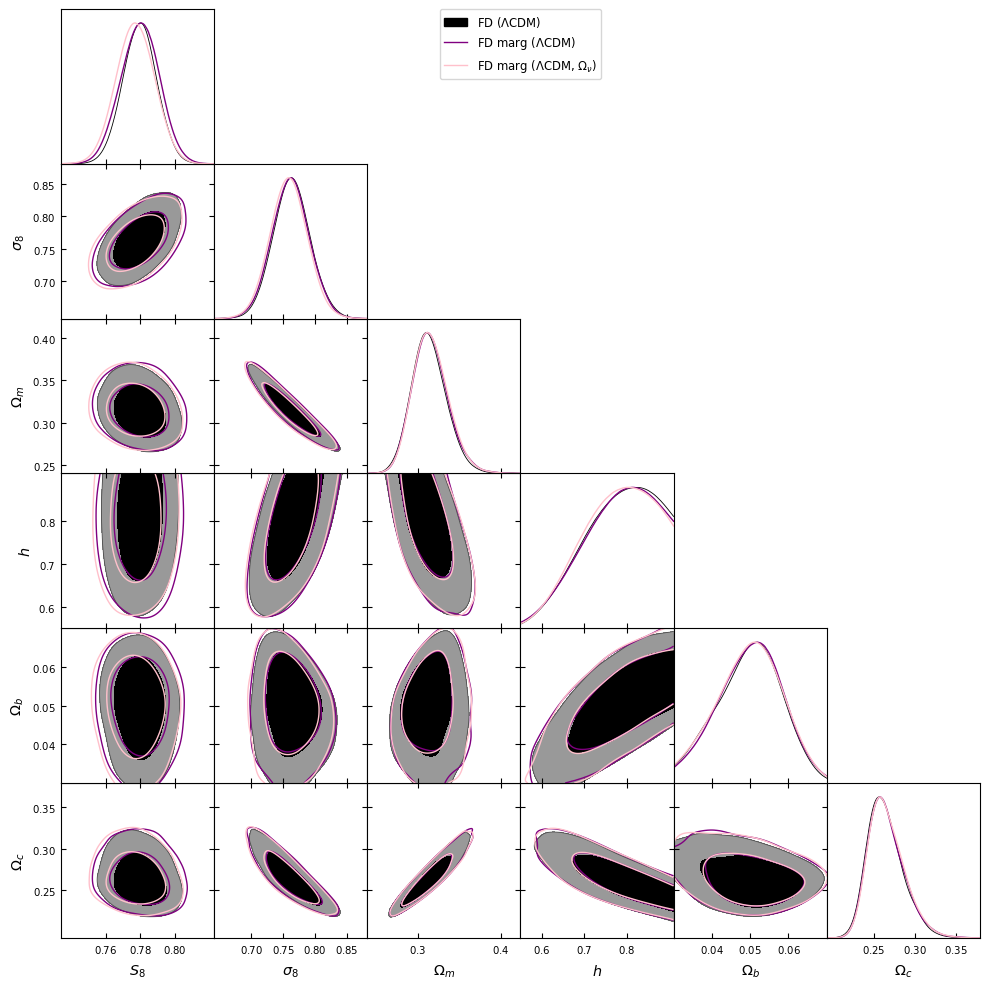

In [37]:
# LCDM LSS: Effect of neutrinos (negligible)
chains = ["FD", "FDm", 'FDm_nu']

parameters = ['S8', 'sigma8', 'Omega_m', 'h', 'Omega_b', 'Omega_c']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, True],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])

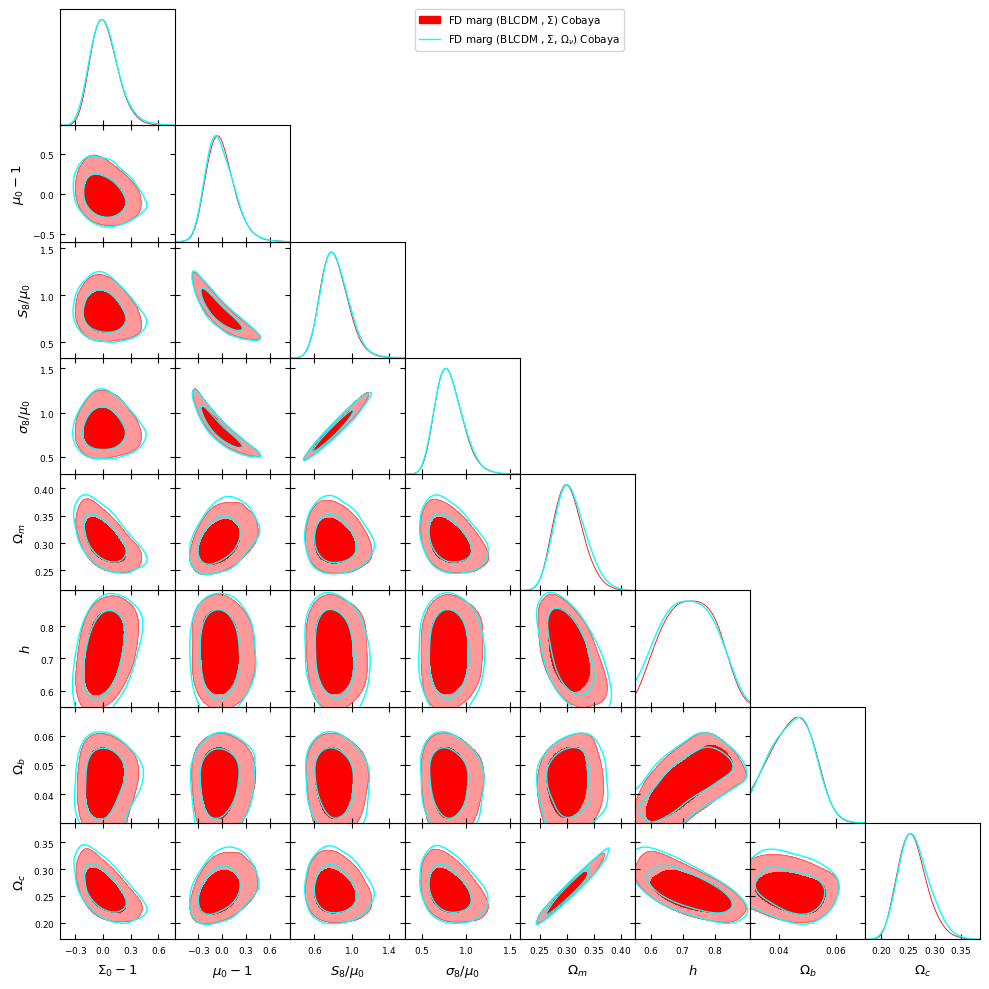

In [87]:
# BLCDM LSS: Effect of neutrinos (negligible)
chains = ["FDm_BLCDM", 'FDm_BLCDM_nu']

parameters = ['dSigma_0', 'dmu_0', 'S8_mu0', 'sigma8_mu0', 'Omega_m', 'h', 'Omega_b', 'Omega_cdm']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, True],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])

### LCDM vs BLCDM

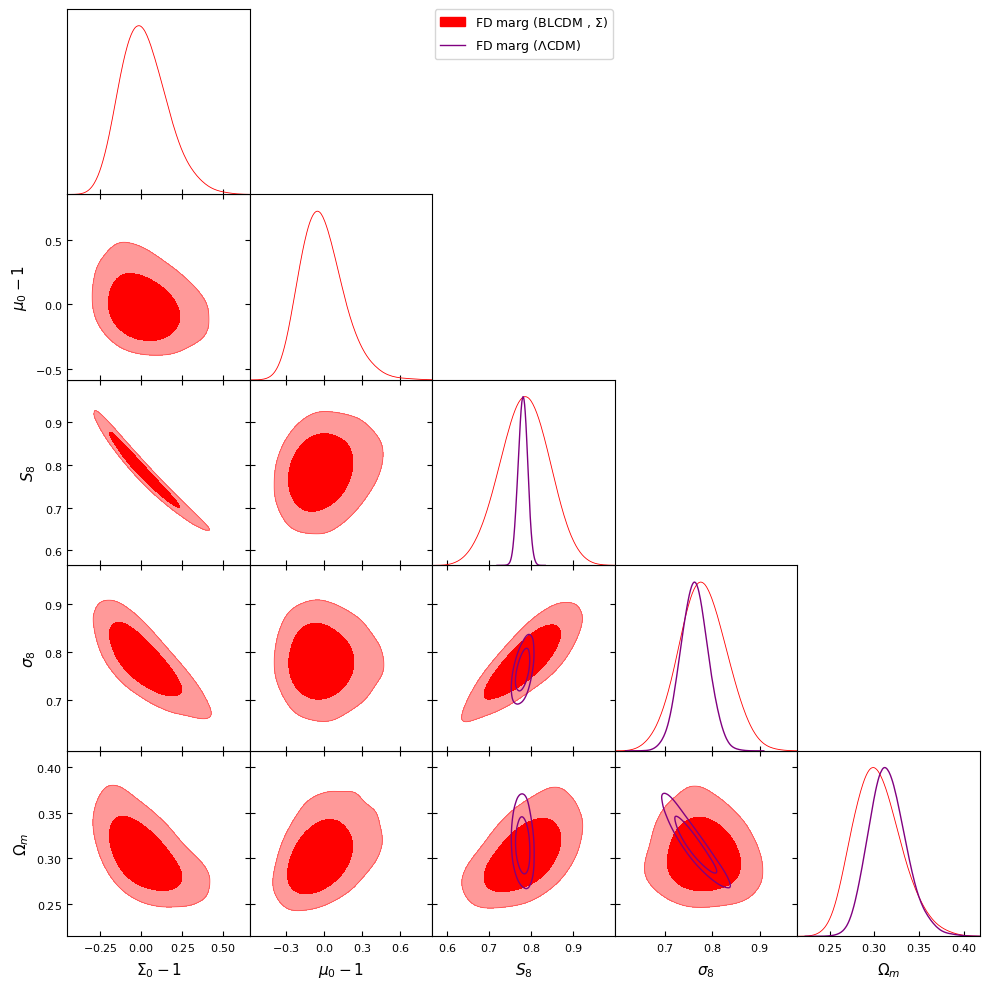

In [23]:
# BLCDM vs LCDM
chains = ['FDm_Sigma', "FDm"]

# parameters = ['dSigma_0', 'dmu_0', 'S8_mu0', 'sigma8_mu0', 'Omega_m']
parameters = ['dSigma_0', 'dmu_0', 'S8', 'sigma8', 'Omega_m']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, True],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])

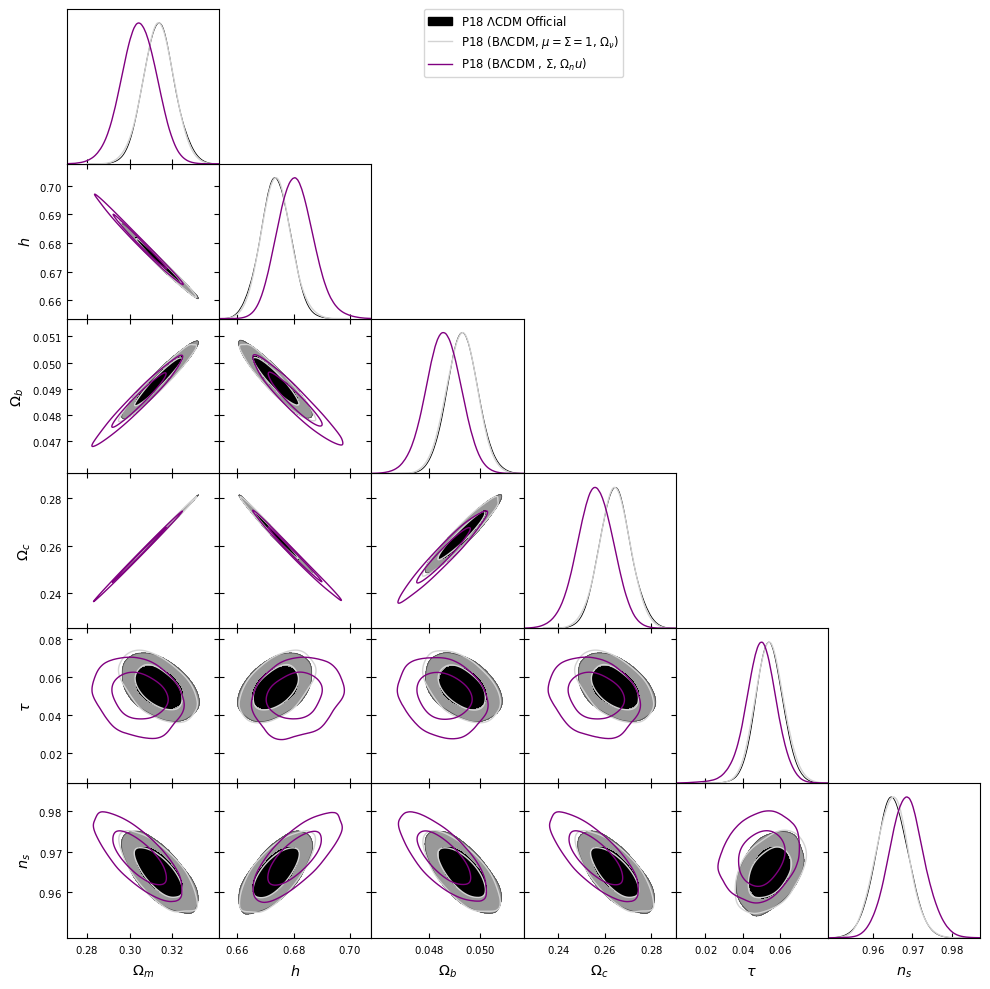

In [25]:
# Planck 2018: BLCDM vs LCDM
chains = ['P18_official', 'P18_lcdm_nu', "P18_Sigma_nu"]

parameters = ['Omega_m', 'h', 'Omega_b', 'Omega_c', 'tau_reio', 'n_s']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, True],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])

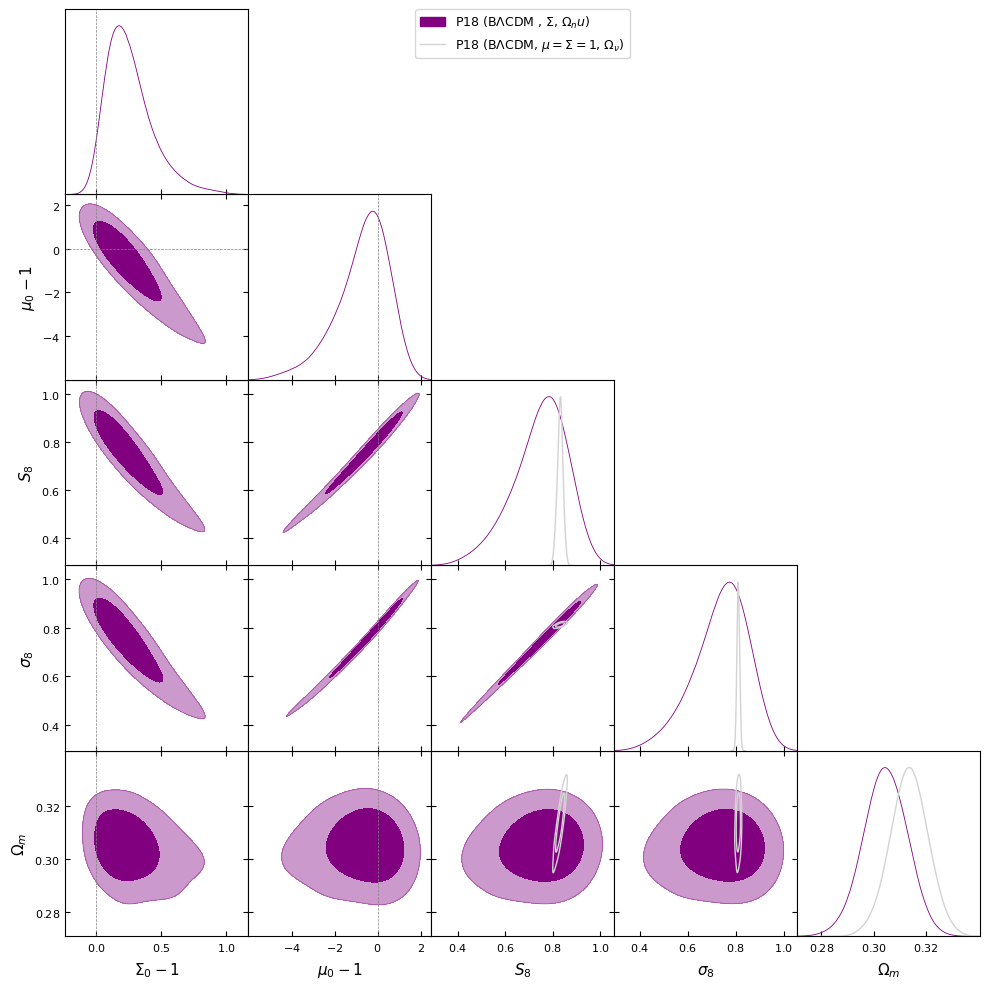

In [20]:
# Planck 2018: BLCDM mu/Sigma params
chains = ["P18_Sigma_nu", "P18_lcdm_nu"]

parameters = ['dSigma_0', 'dmu_0', 'S8', 'sigma8', 'Omega_m']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, True],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1], markers={'dSigma_0': 0, 'dmu_0': 0})

### P18 vs LSS

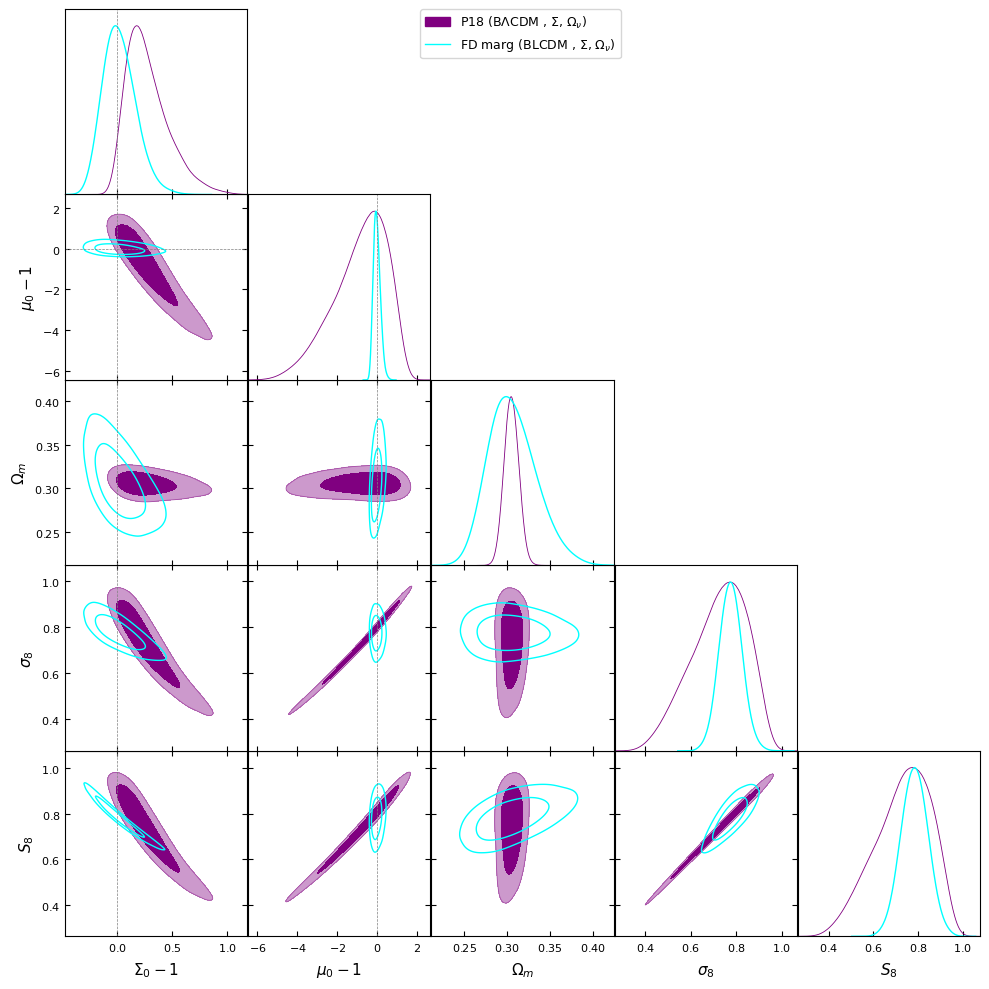

In [95]:
# Planck 2018 vs LSS: BLCDM mu/Sigma params
chains = ["P18_Sigma_nu", "FDm_Sigma_nu"]

parameters = ['dSigma_0', 'dmu_0', 'Omega_m', 'sigma8', 'S8']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, True],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1], markers={'dSigma_0': 0, 'dmu_0': 0})

In [133]:
key = 'FDm_P18_nu'
results[key] = load_chain('./chains/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu',
                           r'FD marg + P18 (B$\Lambda$CDM , $\mu = \Sigma = 1$, $\Omega_\nu$)', 'pink', 0.15)
print(results[key]['R-1'])

key = 'FDm_P18_nu_nocovmat'
results[key] = load_chain('./chains/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu_nocovmat/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu_nocovmat',
                           r'FD marg + P18 (B$\Lambda$CDM , $\mu = \Sigma = 1$, $\Omega_\nu$) nocovmat', 'red', 0.15)
print(results[key]['R-1'])


key = 'FDm_P18_Sigma_nu'
results[key] = load_chain('./chains/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_mgclass_fs_lcdm_nu/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_mgclass_fs_lcdm_nu',
                           r'FD marg + P18 (B$\Lambda$CDM , $\Sigma$, $\Omega_\nu$) ', 'purple', 0.15)
print(results[key]['R-1'])

261.61133572352304
None
None


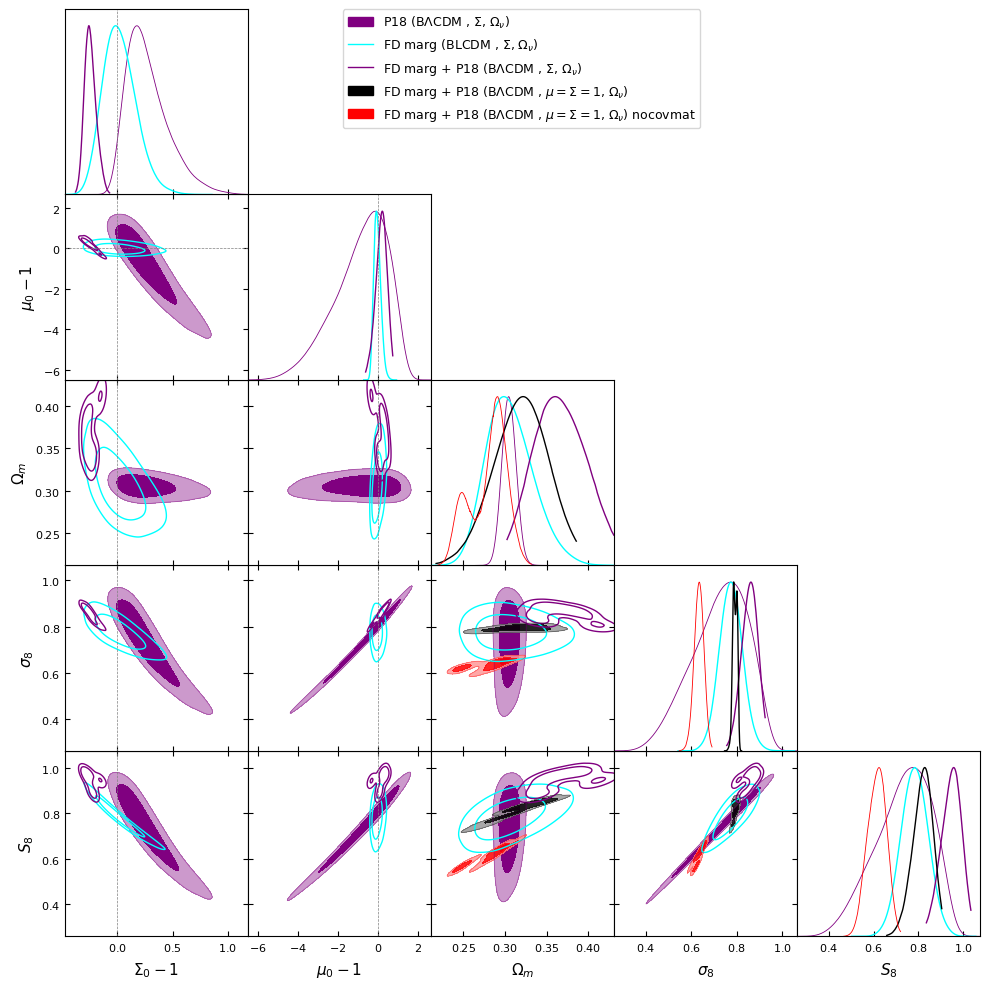

In [134]:
# Planck 2018 vs LSS: BLCDM mu/Sigma params
chains = ["P18_Sigma_nu", "FDm_Sigma_nu", "FDm_P18_Sigma_nu", "FDm_P18_nu", "FDm_P18_nu_nocovmat"]

parameters = ['dSigma_0', 'dmu_0', 'Omega_m', 'sigma8', 'S8']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]
colors[-2] = 'black'

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, True],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1], markers={'dSigma_0': 0, 'dmu_0': 0})

### Prepare MCMC bestfit & covariance for P18 + FD

In [78]:
m = results['FDm_Sigma_nu']['MCSamples']
m.getParamSampleDict(np.argmin(m.loglikes))

{'weight': 1.0,
 'loglike': 654.85024,
 'parameters_smg__1': -0.015607658,
 'parameters_smg__2': 0.023184151,
 'A_sE9': 1.3390319,
 'Omega_cdm': 0.24505428,
 'Omega_b': 0.051654327,
 'h': 0.86666311,
 'n_s': 0.90449861,
 'bias_DESgc__0_b1': 1.512434,
 'bias_DESgc__1_b1': 1.8361268,
 'bias_DESgc__2_b1': 1.800198,
 'bias_DESgc__3_b1': 2.1895425,
 'bias_DESgc__4_b1': 2.3108653,
 'bias_DECALS__0_b1': 1.1767304,
 'bias_DECALS__1_b1': 1.4293657,
 'bias_DECALS__2_b1': 1.3697764,
 'bias_DECALS__3_b1': 1.8327366,
 'bias_eBOSS__0_b1': 2.3771486,
 'bias_eBOSS__1_b1': 2.5334137,
 'bias_A_IA': 0.36123261,
 'limber_eta_IA': -1.9536463,
 'A_s': 1.3390319e-09,
 'sigma8': 0.7827889,
 'S8': 0.77960717,
 'chi2': 1277.8153,
 'chi2__cl_like.ClLike': 1277.8153,
 'Omega_c': 0.24505428,
 'Omega_m': 0.296708607,
 'dmu_0': -0.010976731536287594,
 'dgamma_0': 0.05516947125213356,
 'dSigma_0': 0.01630521385231234,
 'dmu_0_DES': -0.010976731536287594,
 'dgamma_0_DES': 0.05516947125213356,
 'dSigma_0_DES': 0.016305

In [79]:
m = results['P18_Sigma_nu']['MCSamples']
m.getParamSampleDict(np.argmin(m.loglikes))

{'weight': 19.0,
 'loglike': 1408.6848,
 'parameters_smg__1': 0.15778128,
 'parameters_smg__2': 0.18107956,
 'A_sE9': 2.0782968,
 'Omega_cdm': 0.25471936,
 'Omega_b': 0.048387292,
 'h': 0.68079582,
 'n_s': 0.97031705,
 'tau_reio': 0.050405076,
 'A_planck': 1.0019565,
 'calib_100T': 0.99981195,
 'calib_217T': 0.9977995,
 'A_cib_217': 45.341597,
 'xi_sz_cib': 0.81781549,
 'A_sz': 6.2814781,
 'ksz_norm': 1.247755,
 'gal545_A_100': 9.113188,
 'gal545_A_143': 11.506131,
 'gal545_A_143_217': 20.11185,
 'gal545_A_217': 95.427536,
 'ps_A_100_100': 254.93383,
 'ps_A_143_143': 49.0766,
 'ps_A_143_217': 52.798629,
 'ps_A_217_217': 121.39318,
 'galf_TE_A_100': 0.12034592,
 'galf_TE_A_100_143': 0.17002757,
 'galf_TE_A_100_217': 0.54366813,
 'galf_TE_A_143': 0.28302629,
 'galf_TE_A_143_217': 0.70282729,
 'galf_TE_A_217': 2.0780098,
 'A_s': 2.0782968e-09,
 'sigma8': 0.81265699,
 'S8': 0.81872445,
 'chi2__CMB': 2770.9843,
 'minuslogprior': 23.192657,
 'minuslogprior__0': 20.995482,
 'minuslogprior__SZ

In [65]:
# from scipy.linalg import block_diag

# We remove the first columns of P18's covmats to avoid having the same parameters repeated.
# Recall adding the headers by hand once the files are produced.

# covs = {'FDm_Sigma_nu': np.loadtxt("./chains/FD_Garcia-Garcia2021_dzMarg_mMarg_mgclass_fs_lcdm_nu/FD_Garcia-Garcia2021_dzMarg_mMarg_mgclass_fs_lcdm_nu.covmat"),
#         'P18_Sigma_nu': np.loadtxt("./chains/P18_mgclass_fs_lcdm_nu/P18_mgclass_fs_lcdm_nu.covmat")[7:][:, 7:],
#         'FDm_nu': np.loadtxt("./chains/FD_Garcia-Garcia2021_dzMarg_mMarg_nu/FD_Garcia-Garcia2021_dzMarg_mMarg_nu.covmat"),
#         'P18_lcdm_nu': np.loadtxt("./chains/P18_lcdm_nu/P18_lcdm_nu.covmat")[5:][:, 5:]}

# np.savetxt('./input/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_mgclass_fs_lcdm_nu.covmat', block_diag(covs['FDm_Sigma_nu'], covs['P18_Sigma_nu']))
# np.savetxt('./input/FD_Garcia-Garcia2021_dzMarg_mMarg_P18_lcdm_nu.covmat', block_diag(covs['FDm_nu'], covs['P18_lcdm_nu']))

# Tests

## Marg vs no marg

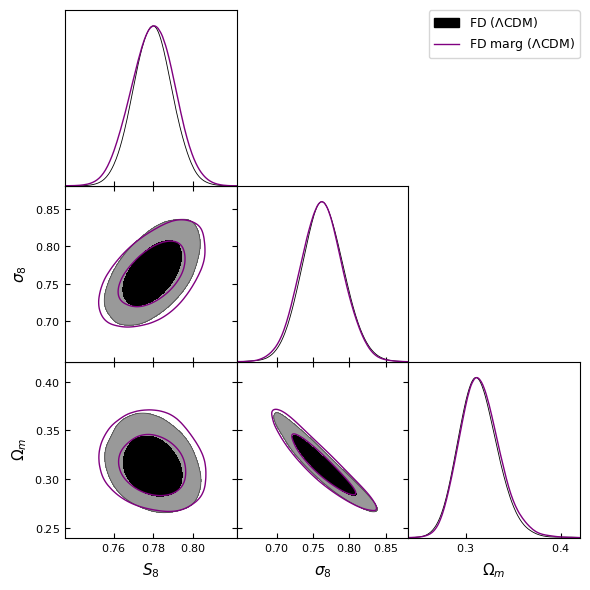

In [113]:
# Marg vs no marg in Cobaya

# Check marginalization & Cobaya vs MontePython
chains = ['FD',
          'FDm']

parameters = ['S8', 'sigma8', 'Omega_m']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])

## Dragging vs no dragging

In [29]:
key = 'FDm2'
results[key] = load_chain('../../xCell-likelihoods/ClLike/examples/chains/FD_Garcia-Garcia2021_dzMarg_mMarg_nodrag/FD_Garcia-Garcia2021_dzMarg_mMarg',
                           r'FD marg ($\Lambda$CDM) Cobaya w/o dragging', 'green', 0.15)
print(results[key]['R-1'])

0.007084442061853649


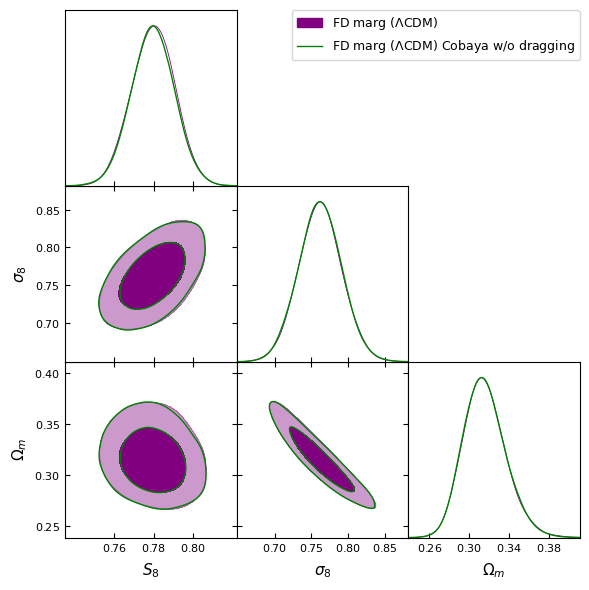

In [30]:
# Marg vs no marg in Cobaya

# Check marginalization & Cobaya vs MontePython
chains = ['FDm',
          'FDm2']

parameters = ['S8', 'sigma8', 'Omega_m']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])

## MontePython vs Cobaya

In [114]:
## MontePython runs
# LCDM
key = 'FDm_MP'
results[key] = load_chain('../../montepython_cgg_emilio/chains/cl_cross_corr_v4_blcdm/cl_cross_corr_v3_FD_dzMarg_mMarg_lcdm/2022-12-22_10000000_',
                           r'FD marg ($\Lambda$CDM) MP', 'g', 0.15)
print(results[key]['R-1'])

key = 'FD_MP'
results[key] = load_chain('../../montepython_cgg_emilio/chains/cl_cross_corr_v3_DES_K1000_all_mag_correctMag_CLASS/2021-09-17_10000000_',
                           r'FD ($\Lambda$CDM) MP', 'k', 0.15)
print(results[key]['R-1'])

# BLCDM
key = 'FD_Sigma_MP'
results[key] = load_chain('../../montepython_cgg_emilio/chains/cl_cross_corr_v4_blcdm/cl_cross_corr_v4_FD_mgclass_fs_hmcode_lcdm_ovs4_Sigma/2022-09-28_10000000_',
                           r'FD ($\Sigma$) MP', 'k', 0.15)
print(results[key]['R-1'])

key = 'FDm_Sigma_MP'
results[key] = load_chain('../../montepython_cgg_emilio/chains/cl_cross_corr_v4_blcdm/cl_cross_corr_v4_FD_dzMarg_mMarg_mgclass_fs_hmcode_lcdm_ovs4_Sigma/2022-12-21_10000000_',
                           r'FD marg ($\Sigma$) MP', 'g', 0.15)
print(results[key]['R-1'])


0.01838113829923001
0.03863682010908302
0.03533890335194117
0.017230168602429385


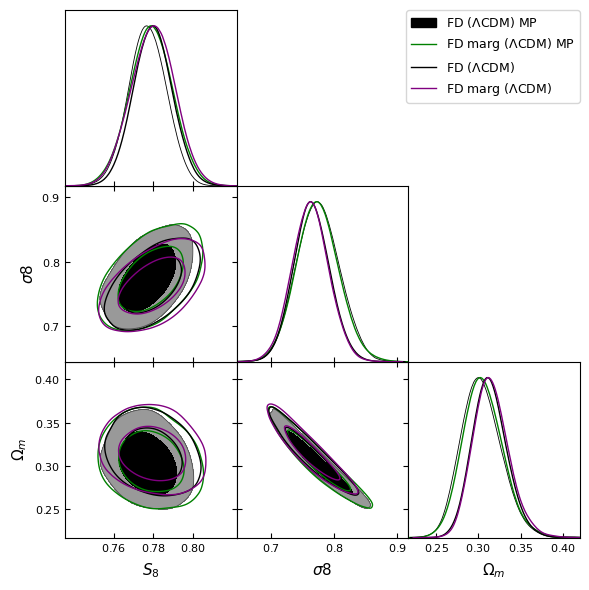

In [115]:
# Check marginalization & Cobaya vs MontePython
chains = ['FD_MP',
          'FDm_MP',
          'FD',
          'FDm']

parameters = ['S8', 'sigma8', 'Omega_m']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])

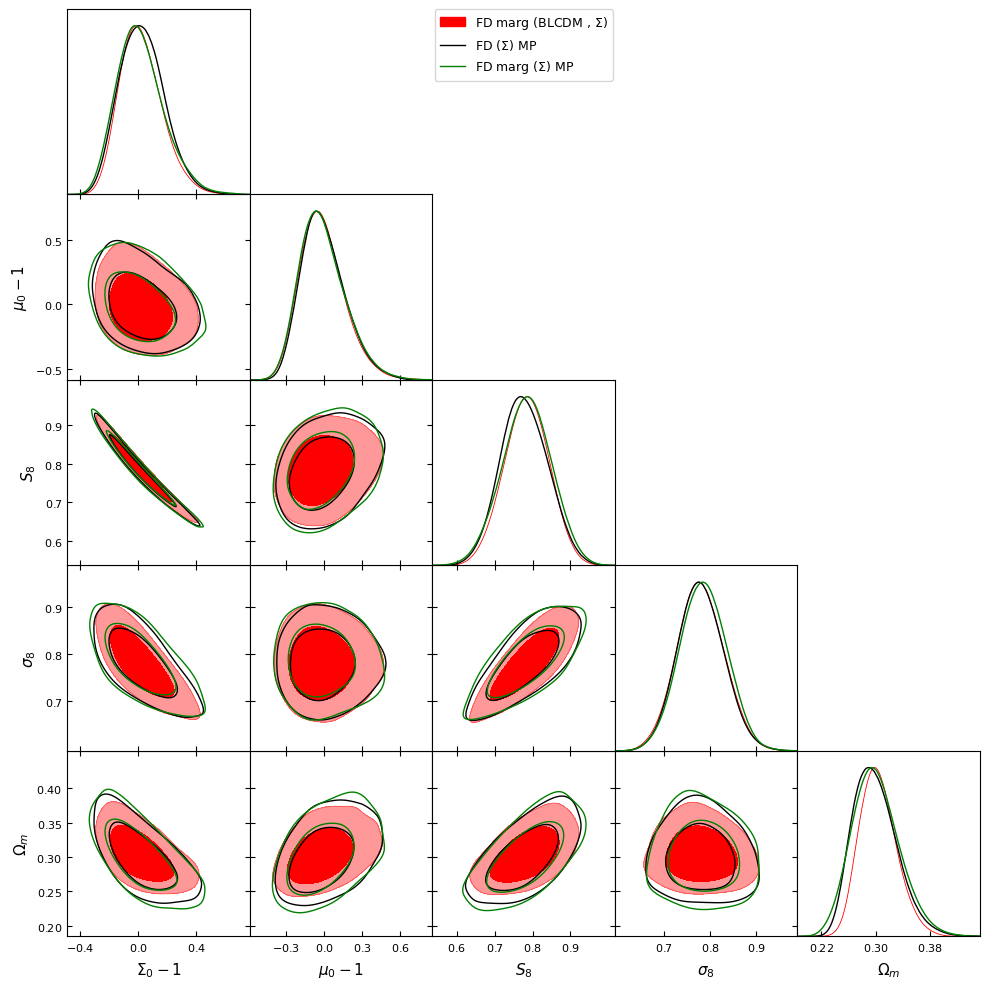

In [117]:
# BLCDM Cobaya vs MontePython
chains = ['FDm_Sigma', 'FD_Sigma_MP', 'FDm_Sigma_MP']

parameters = ['dSigma_0', 'dmu_0', 'S8', 'sigma8', 'Omega_m']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(MCSamples, parameters, filled=[True, False, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])

## Testing P18 lkl

In [38]:
# Running with the official classy implementation to make sure mine also works

# Originally I was running without neutrinos. One needs to add them to recover
# the official results
key = 'P18_lcdm_classy'
results[key] = load_chain('./chains/P18_lcdm_classy/P18_lcdm_classy',
                           r'P18 ($\Lambda$CDM) classy', 'gray', 0.15)
print(results[key]['R-1'])

key = 'P18_lcdm_classy_nu'
results[key] = load_chain('./chains/P18_lcdm_classy_nu/P18_lcdm_classy_nu',
                           r'P18 ($\Lambda$CDM $\Omega_\nu$) classy', 'gray', 0.15)
print(results[key]['R-1'])

0.006018295545233088
None


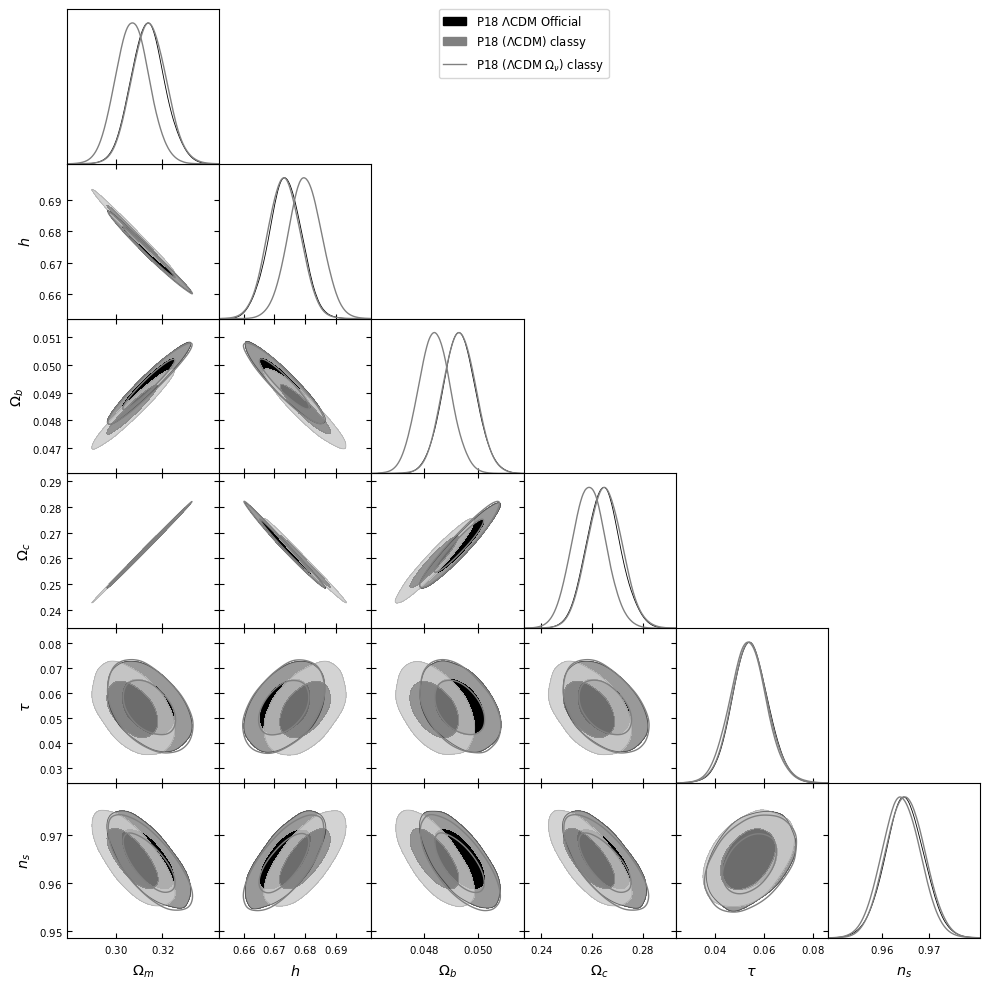

In [4]:
# P18 (LCDM) vs P18 official ---> You need massive neutrinos!!

# BLCDM vs LCDM
chains = ['P18_official', 'P18_lcdm_classy', 'P18_lcdm_classy_nu'] #, 'P18_Sigma']

parameters = ['Omega_m', 'h', 'Omega_b', 'Omega_c', 'tau_reio', 'n_s']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(MCSamples, parameters, filled=[True, True, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])

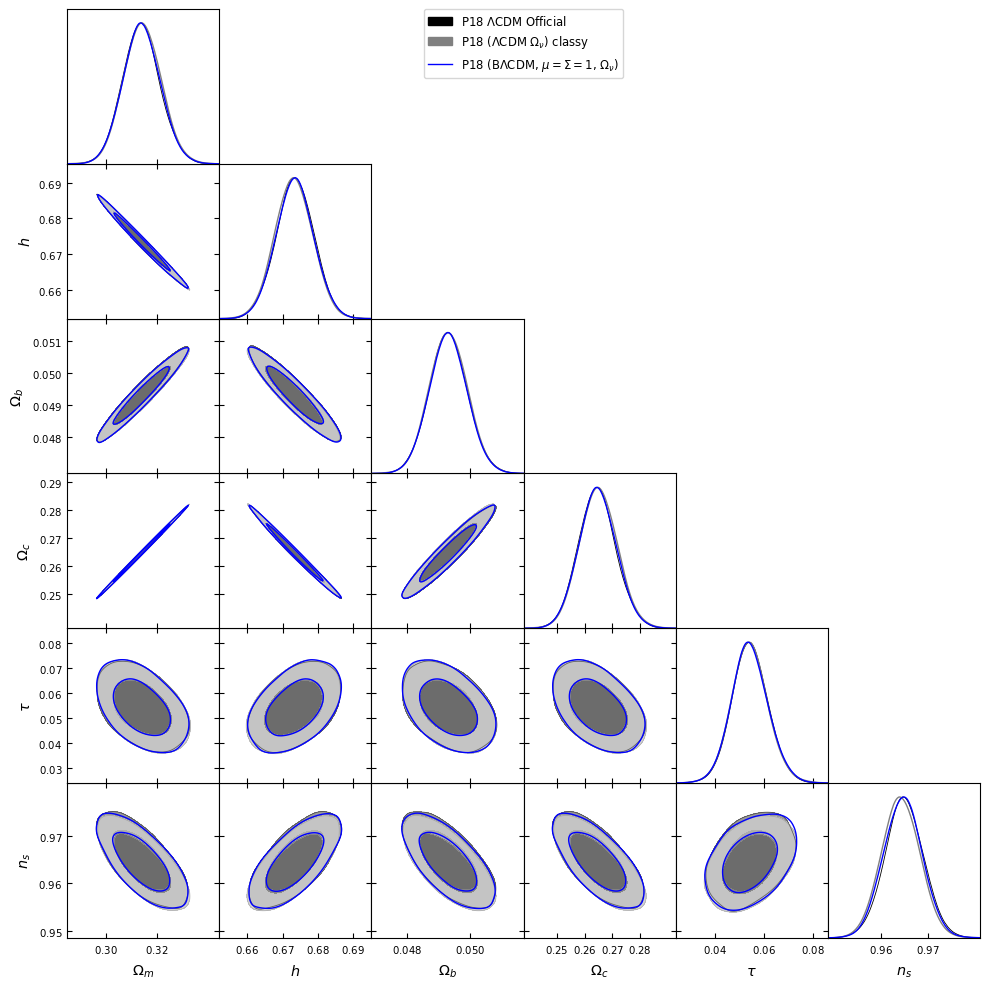

In [40]:
# P18 (LCDM) vs P18 official ---> You need massive neutrinos!!

# BLCDM vs LCDM
chains = ['P18_official', 'P18_lcdm_classy_nu', 'P18_lcdm_nu'] #, 'P18_Sigma']

parameters = ['Omega_m', 'h', 'Omega_b', 'Omega_c', 'tau_reio', 'n_s']

MCSamples = [results[i]['MCSamples'] for i in chains]
labels = [results[i]['label'] for i in chains]
colors = [results[i]['color'] for i in chains]
colors[-1] = 'blue'

g = plots.get_subplot_plotter(width_inch=10)
g.triangle_plot(MCSamples, parameters, filled=[True, True, False, False],
                contour_colors=colors, legend_labels=labels,
                contour_lws=[None, 1, 1, 1])

# Likelihood tests

## Planck

In [8]:
from cobaya.model import get_model
import numpy as np

# import classy
info = {"params": {"A_s": 2.23e-9,
                   "Omega_cdm": 0.25,
                   "Omega_b": 0.05,
                   "h": 0.67,
                   "n_s": 0.96,
                   #"n_s": {"prior": {"min": 0.8, "max": 1.2}}
                   },
        "theory": {"classy": {"extra_args": {"lensing": "yeah",
                                             "non linear": "hmcode",
                                             "z_reio": 11.357}}},
        "likelihood": {"planck_2018_lowl.TT": None,
                       "planck_2018_lowl.EE": None,
                       "planck_2018_highl_plik.TTTEEE": None,
                       "planck_2018_lensing.clik": None
                       },
        "output": "dum",
        "debug": False}

model = get_model(info)
point = dict(zip(model.parameterization.sampled_params(),
                 model.prior.sample(ignore_external=True, random_state=0)[0]))
print(point)
print()
loglikes, derived = model.loglikes(point)
print()
print(loglikes)
print(loglikes[0])
np.savez('classy_cl_hmcode.npz', **model.provider.get_Cl(units="FIRASmuK2"))

[model] *WARNING* Ignored blocks/options: ['output']
[prior] *WARNING* External prior 'SZ' loaded. Mind that it might not be normalized!
[classy] `classy` module loaded successfully from /mnt/zfsusers/gravityls_3/codes/cobaya_packages/code/classy/python/build/lib.linux-x86_64-3.9
[planck_2018_lowl.tt] `clik` module loaded successfully from /mnt/zfsusers/gravityls_3/codes/cobaya_packages/code/planck/code/plc_3.0/plc-3.1/lib/python/site-packages/clik
[planck_2018_lowl.ee] `clik` module loaded successfully from /mnt/zfsusers/gravityls_3/codes/cobaya_packages/code/planck/code/plc_3.0/plc-3.1/lib/python/site-packages/clik
[planck_2018_highl_plik.ttteee] `clik` module loaded successfully from /mnt/zfsusers/gravityls_3/codes/cobaya_packages/code/planck/code/plc_3.0/plc-3.1/lib/python/site-packages/clik
[planck_2018_lensing.clik] `clik` module loaded successfully from /mnt/zfsusers/gravityls_3/codes/cobaya_packages/code/planck/code/plc_3.0/plc-3.1/lib/python/site-packages/clik
{'A_planck': 1.0

In [9]:
import numpy as np
from classy import Class
cosmo = Class()
cosmo.set({"A_s": 2.23e-9,
                   "Omega_cdm": 0.25,
                   "Omega_b": 0.05,
                   "h": 0.67,
                   "n_s": 0.96,
                   #"n_s": {"prior": {"min": 0.8, "max": 1.2}}
                   })
cosmo.set({"lensing": "yeah", "non linear": "halofit", "output": 'tCl, pCl, lCl',
           "start_small_k_at_tau_c_over_tau_h": 1e-4,
           "start_large_k_at_tau_h_over_tau_k": 1e-4,
           "perturb_sampling_stepsize": 0.05,
           "l_logstep": 1.045,
           "l_linstep": 50
})
cosmo.compute()
cl = cosmo.lensed_cl()

# Copied from montepython
T = cosmo.T_cmb()
for key in cl.keys():
    # All quantities need to be multiplied by this factor, except the
    # phi-phi term, that is already dimensionless
    # phi cross-terms should only be multiplied with this factor once
    if key not in ['pp', 'ell', 'tp', 'ep']:
        cl[key] *= (T*1.e6)**2
    elif key in ['tp', 'ep']:
        cl[key] *= (T*1.e6)
                
np.savez('classy_blcdm_cl.npz', **cl)

In [7]:
import numpy as np
from classy import Class
cosmo = Class()
cosmo.set({"A_s": 2.23e-9,
                   "Omega_cdm": 0.25,
                   "Omega_b": 0.05,
                   "h": 0.67,
                   "n_s": 0.96,
                   #"n_s": {"prior": {"min": 0.8, "max": 1.2}}
                   "parameters_smg": "0, 0",  # dmu
                   "expansion_smg": 0.7,    # DE, tuned
                   })
cosmo.set({"lensing": "yeah", "non linear": "halofit", "output": 'tCl, pCl, lCl',
                                     "Omega_Lambda": 0,
                                     "Omega_fld": 0,
                                     "Omega_smg": -1,
                                     "non linear": 'halofit',
                                     "gravity_model": "mgclass_fs",
                                     "expansion_model": "lcdm",
                                     "use_Sigma": "yes",
                                     "output": "tCl, lCl, pCl",
                                     "lensing": 'yes'}
          )
cosmo.compute()
cl = cosmo.lensed_cl()

# Copied from montepython
T = cosmo.T_cmb()
for key in cl.keys():
    # All quantities need to be multiplied by this factor, except the
    # phi-phi term, that is already dimensionless
    # phi cross-terms should only be multiplied with this factor once
    if key not in ['pp', 'ell', 'tp', 'ep']:
        cl[key] *= (T*1.e6)**2
    elif key in ['tp', 'ep']:
        cl[key] *= (T*1.e6)
                
np.savez('classy_blcdm_muSigma_cl.npz', **cl)

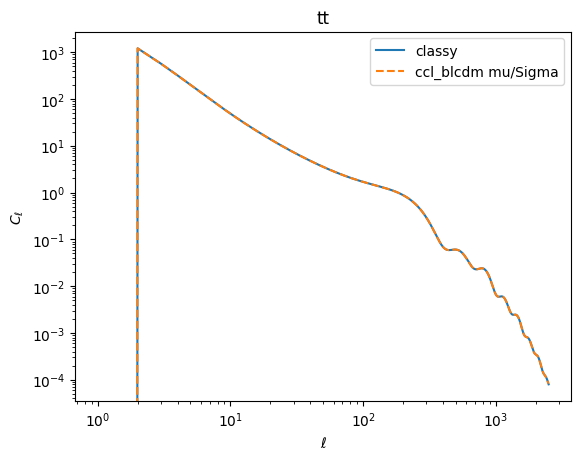

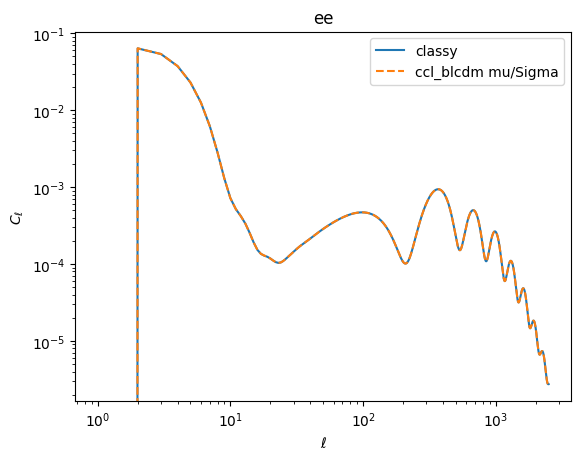

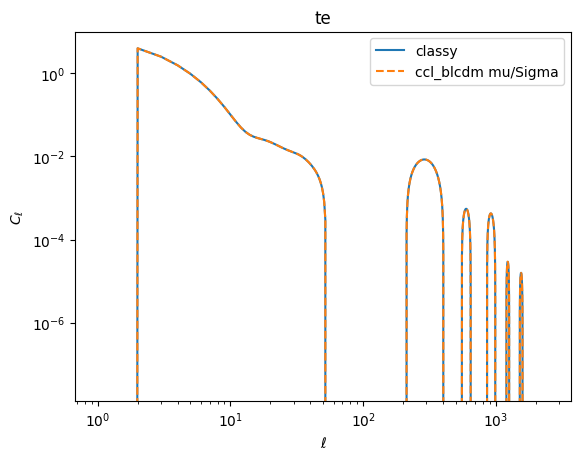

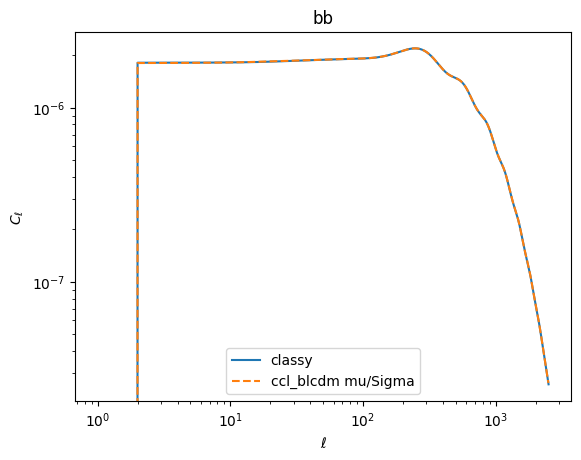

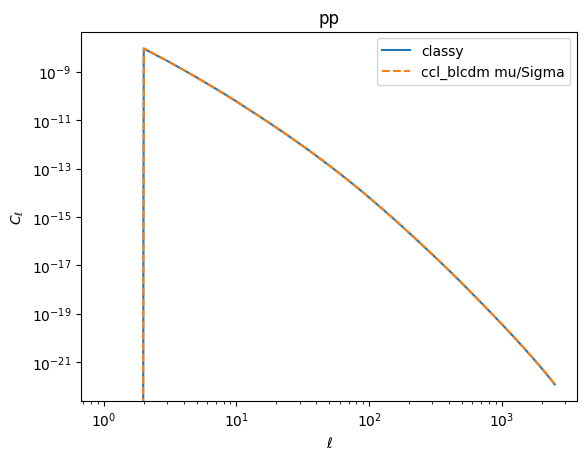

NameError: name 'T' is not defined

In [7]:
cl1 = np.load('classy_cl.npz')
# cl2 = np.load('classy_blcdm_cl.npz')
cl3 = np.load('classy_blcdm_muSigma_cl.npz')

from matplotlib import pyplot as plt

for k, v in cl1.items():
    if k == "ell":
        continue
    if k == 'tp':
        plt.semilogx(cl1['ell'], cl1[k] / (T*1e6), label="classy")
    else:
        plt.semilogx(cl1['ell'], cl1[k], label="classy")
    # plt.loglog(cl2['ell'], cl2[k], ls="--", label="ccl_blcdm")
    plt.loglog(cl3['ell'], cl3[k], ls="--", label="ccl_blcdm mu/Sigma")
    plt.xlabel("$\ell$")
    plt.ylabel("$C_\ell$")
    plt.title(k)
    plt.legend()
    plt.show()
    plt.close()

In [10]:
list(cl2.keys())

['arr_0']

In [33]:
import numpy as np
from classy import Class
cosmo = Class()
cosmo.set({"A_s": 2.23e-9,
                   "Omega_cdm": 0.25,
                   "Omega_b": 0.05,
                   "h": 0.67,
                   "n_s": 0.96,
                   #"n_s": {"prior": {"min": 0.8, "max": 1.2}}
                   })
cosmo.set({"lensing": "yeah", "non linear": "halofit", "output": 'tCl, pCl, lCl, mPk', 'z_max_pk': 4, 'P_k_max_1/Mpc': 100,
           "start_small_k_at_tau_c_over_tau_h": 1e-4,
           "start_large_k_at_tau_h_over_tau_k": 1e-4,
           "perturb_sampling_stepsize": 0.05,
           "l_logstep": 1.045,
           "l_linstep": 50
})
cosmo.compute()
cl = cosmo.lensed_cl()

# Copied from montepython
T = cosmo.T_cmb()
for key in cl.keys():
    # All quantities need to be multiplied by this factor, except the
    # phi-phi term, that is already dimensionless
    # phi cross-terms should only be multiplied with this factor once
    if key not in ['pp', 'ell', 'tp', 'ep']:
        cl[key] *= (T*1.e6)**2
    elif key in ['tp', 'ep']:
        cl[key] *= (T*1.e6)
        
pk, k, z = cosmo.get_pk_and_k_and_z()

In [34]:
import numpy as np
from classy import Class
cosmo2 = Class()
cosmo2.set({"A_s": 2.23e-9,
                   "Omega_cdm": 0.25,
                   "Omega_b": 0.05,
                   "h": 0.67,
                   "n_s": 0.96,
                   #"n_s": {"prior": {"min": 0.8, "max": 1.2}}
                   "parameters_smg": "0, 0",  # dmu
                   "expansion_smg": 0.7,    # DE, tuned
                   })
cosmo2.set({"lensing": "yeah", "non linear": "halofit", "output": 'tCl, pCl, lCl, mPk', 'z_max_pk': 4, 'P_k_max_1/Mpc': 100,
                                     "Omega_Lambda": 0,
                                     "Omega_fld": 0,
                                     "Omega_smg": -1,
                                     "non linear": 'halofit',
                                     "gravity_model": "mgclass_fs",
                                     "expansion_model": "lcdm",
                                     "use_Sigma": "yes",
                                     "lensing": 'yes'}
          )
cosmo2.compute()
cl2 = cosmo2.lensed_cl()

# Copied from montepython
T2 = cosmo2.T_cmb()
for key in cl.keys():
    # All quantities need to be multiplied by this factor, except the
    # phi-phi term, that is already dimensionless
    # phi cross-terms should only be multiplied with this factor once
    if key not in ['pp', 'ell', 'tp', 'ep']:
        cl2[key] *= (T2*1.e6)**2
    elif key in ['tp', 'ep']:
        cl2[key] *= (T2*1.e6)
        
pk2, k2, z2 = cosmo2.get_pk_and_k_and_z()

tt
tt OK
ee
ee OK
te
te OK
bb
bb OK
pp
pp OK
tp


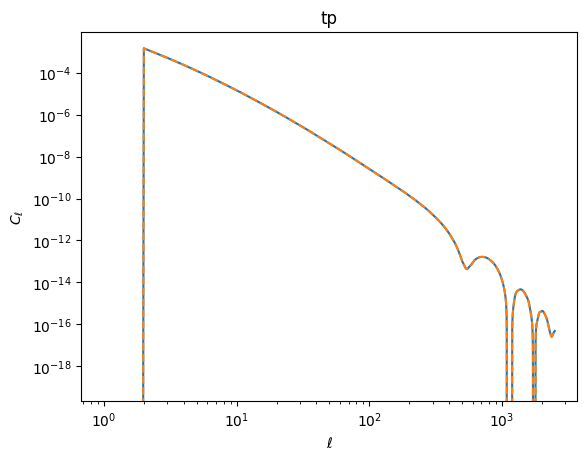

tp OK
ell
ell OK


In [39]:
assert all((pk2.shape == pk.shape, k2.shape == k.shape, z2.shape == z.shape))
assert np.all(np.abs(z2[:-1] / z[:-1] -1) < 1e-5)
assert np.all(np.abs(k2 / k -1) < 1e-5)
assert np.all(np.abs(pk2 / pk - 1) < 1e-2)
for key in cl.keys():
    print(key)
    if not np.all(np.abs(cl2[key][2:] / cl[key][2:] - 1) < 1e-2):
        plt.plot(cl['ell'], cl[key], label="Class-like hi_class (no smg)")
        plt.loglog(cl2['ell'], cl2[key], ls='--', label="mu = Sigma = 1")
        plt.xlabel("$\ell$")
        plt.ylabel("$C_\ell$")
        plt.title(key)
        plt.show()
        plt.close()
    print(key, "OK")

In [9]:
import sacc
s = sacc.Sacc.load_fits("/mnt/extraspace/gravityls_3/sacc_files/cls_FD_covG_dzMarg_mMarg.fits")

DESgc__0 0.0051 3.9951000000000003
DESgc__1 0.0051 3.9951000000000003
DESgc__2 0.0051 0.7051000000000001
DESgc__3 0.0051 1.0050999999999999
DESgc__4 0.0051 1.0951000000000002
DESwl__0 0.0051 3.6351
DESwl__1 0.0051 3.9951000000000003
DESwl__2 0.0051 3.6451000000000002
DESwl__3 0.0051 3.9951000000000003
eBOSS__0 0.52 1.44
eBOSS__1 0.52 2.48
DECALS__0 0.0002999999999999947 0.9986999999999999
DECALS__1 0.0002999999999999947 0.9986999999999999
DECALS__2 0.0002999999999999947 0.9960999999999999
DECALS__3 0.0002999999999999947 0.9960999999999999
KiDS1000__0 0.0 2.5


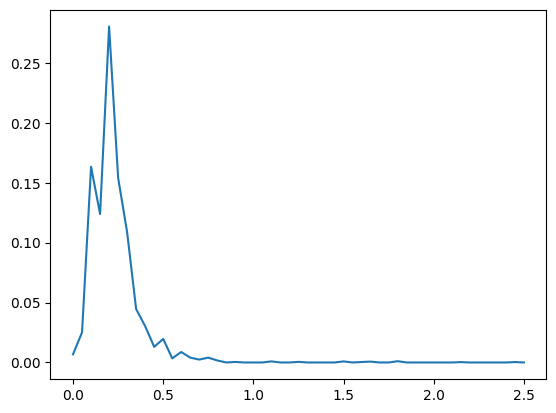

KiDS1000__1 0.0 5.95


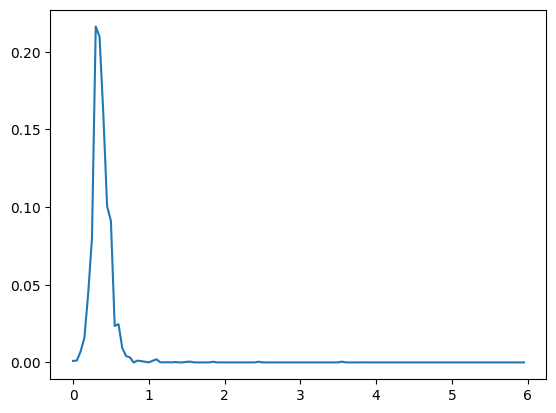

KiDS1000__2 0.0 4.4


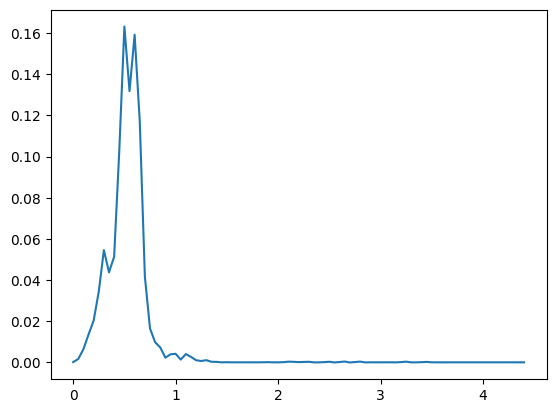

KiDS1000__3 0.0 5.95


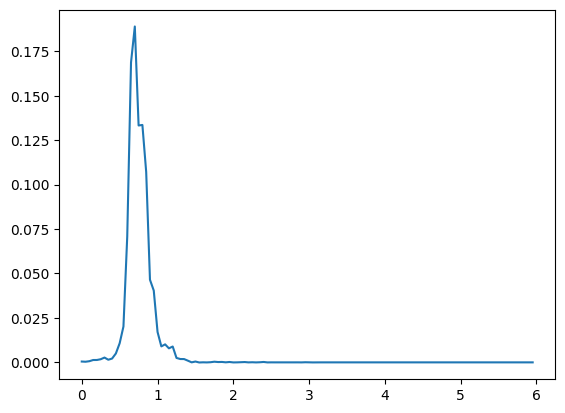

KiDS1000__4 0.0 4.6000000000000005


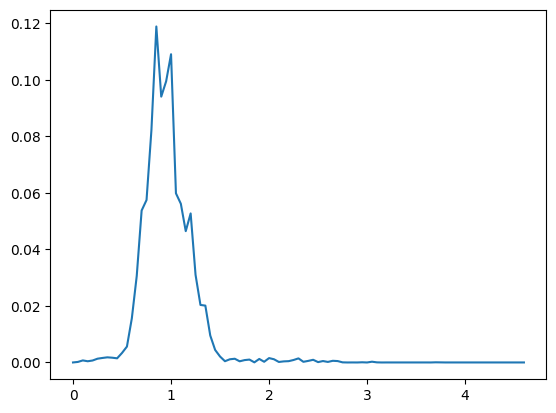

In [18]:
for trn, tr in s.tracers.items():
    try:
        sel = np.cumsum(tr.nz) / np.sum(tr.nz) < 1
        print(trn, tr.z[sel].min(), tr.z[sel].max())
        if 'KiDS' in trn:
            sel = np.cumsum(tr.nz) / np.sum(tr.nz) < 1
            plt.plot(tr.z[sel], tr.nz[sel])
            plt.show()
            plt.close()
    except:
        pass

In [17]:
s.tracers['KiDS1000__3'].nz[0]

0.00046581579000827826

## LSS + Planck

In [31]:
m = results['P18_lcdm_nu']['MCSamples']
print(f'BF chi2 = {m.loglikes.min()}')
bf = m.getParamSampleDict(np.argmin(m.loglikes))

model = get_model('./input/P18_lcdm_nu.yml')
point = {k: bf[k] for k in model.parameterization.sampled_params().keys()}

print(point)
print()
loglikes, derived = model.loglikes(point)
print()
print(loglikes)

BF chi2 = 1404.8363
[model] *WARNING* Ignored blocks/options: ['sampler', 'package_path', 'output']
[prior] *WARNING* External prior 'SZ' loaded. Mind that it might not be normalized!
[planck_2018_lowl.tt] `clik` module loaded successfully from /mnt/zfsusers/gravityls_3/codes/cobaya_packages/code/planck/code/plc_3.0/plc-3.1/lib/python/site-packages/clik
[planck_2018_lowl.ee] `clik` module loaded successfully from /mnt/zfsusers/gravityls_3/codes/cobaya_packages/code/planck/code/plc_3.0/plc-3.1/lib/python/site-packages/clik
[planck_2018_highl_plik.ttteee] `clik` module loaded successfully from /mnt/zfsusers/gravityls_3/codes/cobaya_packages/code/planck/code/plc_3.0/plc-3.1/lib/python/site-packages/clik
[planck_2018_lensing.clik] `clik` module loaded successfully from /mnt/zfsusers/gravityls_3/codes/cobaya_packages/code/planck/code/plc_3.0/plc-3.1/lib/python/site-packages/clik
{'A_sE9': 2.0850243, 'Omega_cdm': 0.26715539, 'Omega_b': 0.049516357, 'h': 0.67133227, 'n_s': 0.9627079, 'tau_rei

In [30]:
m = results['FDm_nu']['MCSamples']
print(f'BF chi2 = {m.loglikes.min()}')
bf = m.getParamSampleDict(np.argmin(m.loglikes))

model = get_model('./input/FD_Garcia-Garcia2021_dzMarg_mMarg_nu.yml')
point = {k: bf[k] for k in model.parameterization.sampled_params().keys()}

print(point)
print()
loglikes, derived = model.loglikes(point)
print()
print(loglikes)

BF chi2 = 649.12381
[model] *WARNING* Ignored blocks/options: ['sampler', 'output']
{'A_sE9': 1.3796581, 'Omega_c': 0.24482751, 'Omega_b': 0.053336925, 'h': 0.85297506, 'n_s': 0.91830701, 'bias_DESgc__0_b1': 1.4987055, 'bias_DESgc__1_b1': 1.8226751, 'bias_DESgc__2_b1': 1.812017, 'bias_DESgc__3_b1': 2.2086483, 'bias_DESgc__4_b1': 2.2686956, 'bias_DECALS__0_b1': 1.1873772, 'bias_DECALS__1_b1': 1.4382155, 'bias_DECALS__2_b1': 1.3830509, 'bias_DECALS__3_b1': 1.8523677, 'bias_eBOSS__0_b1': 2.3925322, 'bias_eBOSS__1_b1': 2.6312218, 'bias_A_IA': 0.37645845, 'limber_eta_IA': -1.5894876}


[-639.17267858]
